### Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("testing_data.csv")

In [2]:
train_df.head()

,ID,x-inv,y-inv,force
0,0,21.581582,-60.00000,223.592139
1,1,36.396396,-59.87988,220.539473
2,2,5.405405,-59.75976,222.776285
3,3,26.946947,-59.63964,207.157711
4,4,9.409409,-59.51952,205.724987


In [3]:
train_df.shape

(1000, 4)

In [ ]:
train_df.describe()

,ID,x-inv,y-inv,force
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,499.500000,1.769251e-15,1.634248e-16,72.209691
std,288.819436,2.312868e+01,3.469303e+01,65.326105
min,0.000000,-4.000000e+01,-6.000000e+01,-10.099132
25%,249.750000,-2.000000e+01,-3.000000e+01,13.954386
50%,499.500000,0.000000e+00,0.000000e+00,54.800617
75%,749.250000,2.000000e+01,3.000000e+01,121.912166
max,999.000000,4.000000e+01,6.000000e+01,223.592139


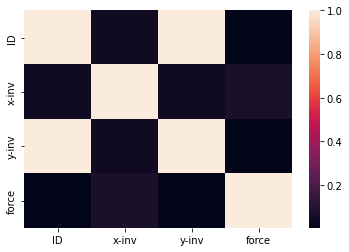

In [ ]:
sns.heatmap(train_df.corr())

In [ ]:
train_df.corr()

,ID,x-inv,y-inv,force
ID,1.000000,0.046897,1.000000,0.004372
x-inv,0.046897,1.000000,0.046897,0.071127
y-inv,1.000000,0.046897,1.000000,0.004372
force,0.004372,0.071127,0.004372,1.000000


### Checking null values

In [ ]:
train_df.isna().sum()

ID       0
x-inv    0
y-inv    0
force    0
dtype: int64

In [ ]:
%matplotlib notebook

# For plotting in 3D
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(train_df['x-inv'], train_df['y-inv'], train_df['force'])

ax.set_xlabel('x-inv')
ax.set_ylabel('y-inv')
ax.set_zlabel('force')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'force')

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline

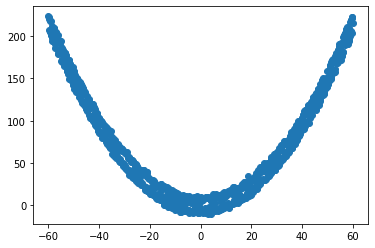

In [ ]:
# Viewing the change wrt y-inv
plt.scatter(train_df['y-inv'], train_df['force'])

Force seems like a quadratic in y_inv

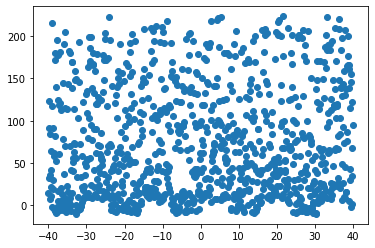

In [ ]:
# viewing the change wrt x-inv
plt.scatter(train_df['x-inv'], train_df['force'])

The distribution wrt x-inv seems to related to a sin (due to its periodic nature) or a high degree polynomial distribution.

## 1. Trying the features of the form - $ \; \;sin(a(\text{x-inv})+b), \;\; (\text{y-inv})^2, \;\; (\text{y-inv})$

In [ ]:
# The (y-inv)^2 features
train_df['y-inv * y-inv'] = train_df['y-inv']*train_df['y-inv']

In [ ]:
train_df.head()

,ID,x-inv,y-inv,force,y-inv * y-inv
0,0,21.581582,-60.00000,223.592139,3600.000000
1,1,36.396396,-59.87988,220.539473,3585.600014
2,2,5.405405,-59.75976,222.776285,3571.228887
3,3,26.946947,-59.63964,207.157711,3556.886616
4,4,9.409409,-59.51952,205.724987,3542.573204


In [ ]:
features = ['x-inv', 'y-inv', 'y-inv * y-inv']
label = ['force']

In [ ]:
from sklearn.model_selection import train_test_split

def normalizeCols(X, cols):
    for c in cols:
        X[c] = (X[c]-X[c].mean())/X[c].std()
        
def dosplit(df, fcols, targetcol):
    X = df.loc[:, fcols]
    y = df[targetcol]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.30, random_state=3)
    return (X_train, X_test, y_train, y_test)

In [ ]:
X_train,X_test,y_train,y_test = dosplit(train_df, features, label)

### SKLearn Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Trying regressin without the sin(a(x-inv)+b) feature
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yhat_test = lr_model.predict(X_test)
mean_squared_error(y_test, yhat_test)

55.33248382706001

In [ ]:
# Brute forcing over 10000 the values of a between -1 and 1
a = np.linspace(-1, 1, 10000)

# Empirically found to be near 0, so just put 0 here
b=[0]

# Saving the best mean square error and its parameters from all choices of a and b
bmse = 1e9
ba = -1
bb = -1

for i in a:
    for j in b:
        X_train['sin(ax+b)'] = np.sin(i*X_train['x-inv'] + j)
        X_test['sin(ax+b)'] = np.sin(i*X_test['x-inv'] + j)
        
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        
        yhat_test = lr_model.predict(X_test)
        bm = mean_squared_error(y_test, yhat_test)
        if(bm < bmse):
            bmse = bm
            ba = i
            bb = j
        

In [ ]:
bmse

9.183275338357161

In [ ]:
ba

-0.39993999399939995

In [ ]:
bb

0

Optimal a = -0.3993993993993994

Optimal b = 0

In [ ]:
ba = -0.3993993993993994
bb = 0

# Adding the feature corresponding to best a and b
X_train['sin(ax+b)'] = np.sin(ba*X_train['x-inv'] + bb)
X_test['sin(ax+b)'] = np.sin(ba*X_test['x-inv'] + bb)

In [131]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
ba = -0.3993993993993994
bb = 0

X_train['sin(ax+b)'] = np.sin(ba*X_train['x-inv'] + bb)
X_test['sin(ax+b)'] = np.sin(ba*X_test['x-inv'] + bb)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
        
yhat_test = lr_model.predict(X_test)
mean_squared_error(y_test, yhat_test)

9.191157022557709

### Final Model 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
ba = -0.3993993993993994
bb = 0

train_df['y-inv * y-inv'] = train_df['y-inv']*train_df['y-inv']
train_df['sin(ax+b)'] = np.sin(ba*train_df['x-inv'] + bb)

In [ ]:
train_df.head()

,ID,x-inv,y-inv,force,y-inv * y-inv,sin(ax+b)
0,0,21.581582,-60.00000,223.592139,3600.000000,-0.720905
1,1,36.396396,-59.87988,220.539473,3585.600014,-0.921243
2,2,5.405405,-59.75976,222.776285,3571.228887,-0.831986
3,3,26.946947,-59.63964,207.157711,3556.886616,0.972983
4,4,9.409409,-59.51952,205.724987,3542.573204,0.578199


In [ ]:
features = ['x-inv', 'y-inv', 'y-inv * y-inv', 'sin(ax+b)']
label = ['force']

In [ ]:
X_tr = train_df.loc[:, features]
y_tr = train_df[label]

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
test_df.head()

,ID,x-inv,y-inv
0,0,14.525453,-60.000000
1,1,33.975398,-59.987999
2,2,-1.532153,-59.975998
3,3,10.525053,-59.963996
4,4,-2.428243,-59.951995


In [ ]:
ba = -0.3993993993993994
bb = 0

test_df['y-inv * y-inv'] = test_df['y-inv']*test_df['y-inv']
test_df['sin(ax+b)'] = np.sin(ba*test_df['x-inv'] + bb)

In [ ]:
X_tes = test_df.loc[:, features]
y_tes = lr_model.predict(X_tes)

In [ ]:
sub_df = pd.DataFrame(test_df['ID'])
sub_df['force'] = y_tes

In [ ]:
sub_df.to_csv("Lreg_sinSub.csv", index=False)

## 2. Trying the polynomial features in x-inv, y-inv

In [4]:
poly_df = train_df.copy()

In [5]:
poly_df

,ID,x-inv,y-inv,force
0,0,21.581582,-60.00000,223.592139
1,1,36.396396,-59.87988,220.539473
2,2,5.405405,-59.75976,222.776285
3,3,26.946947,-59.63964,207.157711
4,4,9.409409,-59.51952,205.724987
...,...,...,...,...
995,995,-2.842843,59.51952,204.279172
996,996,4.444444,59.63964,221.510671
997,997,-24.144144,59.75976,222.373289
998,998,33.273273,59.87988,222.941089


In [6]:
poly_df['y-inv * y-inv'] = poly_df['y-inv']*poly_df['y-inv']
poly_df.head()

,ID,x-inv,y-inv,force,y-inv * y-inv
0,0,21.581582,-60.00000,223.592139,3600.000000
1,1,36.396396,-59.87988,220.539473,3585.600014
2,2,5.405405,-59.75976,222.776285,3571.228887
3,3,26.946947,-59.63964,207.157711,3556.886616
4,4,9.409409,-59.51952,205.724987,3542.573204


In [7]:
from sklearn.model_selection import train_test_split

def normalizeCols(X, cols):
    for c in cols:
        X[c] = (X[c]-X[c].mean())/X[c].std()
        
def dosplitN(df, fcols, targetcol):
    X = df.loc[:, fcols]
    sc = df['x-inv']

    for i in range(50):
      sc = sc * df['x-inv'];
      X['(x-inv)^' + str(i+2)] = sc
    normalizeCols(X, list(X.columns))

    y = df[targetcol]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.30, random_state=3)
    return (X_train, X_test, y_train, y_test)

In [8]:
# poly_df.drop(axis='columns', labels=['sin(ax+b)'], inplace=True)

In [9]:
featcol = ['x-inv', 'y-inv', 'y-inv * y-inv']
targcol = 'force'

In [10]:
# sc = poly_df['x-inv']
# for i in range(5):
#   sc = sc * poly_df['x-inv'];
#   poly_df['(x-inv)^' + str(i+2)] = sc
  
X_train, X_test, y_train, y_test = dosplitN(poly_df, featcol, targcol)

In [11]:
X_train

,x-inv,y-inv,y-inv * y-inv,(x-inv)^2,(x-inv)^3,(x-inv)^4,(x-inv)^5,(x-inv)^6,(x-inv)^7,(x-inv)^8,(x-inv)^9,(x-inv)^10,(x-inv)^11,(x-inv)^12,(x-inv)^13,(x-inv)^14,(x-inv)^15,(x-inv)^16,(x-inv)^17,(x-inv)^18,(x-inv)^19,(x-inv)^20,(x-inv)^21,(x-inv)^22,(x-inv)^23,(x-inv)^24,(x-inv)^25,(x-inv)^26,(x-inv)^27,(x-inv)^28,(x-inv)^29,(x-inv)^30,(x-inv)^31,(x-inv)^32,(x-inv)^33,(x-inv)^34,(x-inv)^35,(x-inv)^36,(x-inv)^37,(x-inv)^38,(x-inv)^39,(x-inv)^40,(x-inv)^41,(x-inv)^42,(x-inv)^43,(x-inv)^44,(x-inv)^45,(x-inv)^46,(x-inv)^47,(x-inv)^48,(x-inv)^49,(x-inv)^50,(x-inv)^51
926,-1.410916,1.476701,1.321784,1.109293,-1.431549,0.904038,-1.191986e+00,0.631492,-9.245688e-01,0.387330,-6.911788e-01,0.193408,-5.051248e-01,0.048505,-3.635289e-01,-0.055486,-2.587387e-01,-0.127703,-1.826161e-01,-0.176253,-1.280452e-01,-0.207668,-8.930836e-02,-0.226947,-6.202045e-02,-0.237788,-4.291413e-02,-0.242872,-2.960241e-02,-0.244101,-2.036588e-02,-0.242813,-1.397913e-02,-0.239931,-9.575936e-03,-0.236087,-6.547991e-03,-0.231707,-4.470393e-03,-0.227074,-3.047656e-03,-0.222372,-2.075057e-03,-0.217719,-1.411206e-03,-0.213184,-9.587208e-04,-0.208810,-6.506917e-04,-0.204617,-4.412393e-04,-0.200614,-2.989644e-04
411,-0.140226,-0.306420,-1.012448,-1.095481,-0.001405,-0.749467,-1.155868e-05,-0.600628,-8.855867e-08,-0.515137,-6.539389e-10,-0.458038,-4.720635e-12,-0.416470,-3.358798e-14,-0.384477,-2.297564e-16,-0.358873,-3.141232e-17,-0.337783,1.127839e-17,-0.320020,4.206583e-18,-0.304793,3.595721e-17,-0.291551,3.513946e-17,-0.279898,2.628424e-17,-0.269540,8.530312e-18,-0.260253,6.496591e-18,-0.251865,-6.847031e-18,-0.244240,2.025990e-17,-0.237269,-9.359671e-18,-0.230863,3.875290e-18,-0.224950,-3.256143e-17,-0.219471,1.050878e-17,-0.214374,-5.781178e-18,-0.209617,4.103216e-17,-0.205164,-1.107139e-17,-0.200984,1.242317e-17
224,1.127002,-0.953883,-0.099675,0.303288,0.729586,-0.076433,3.876038e-01,-0.280597,1.918240e-01,-0.365576,9.149573e-02,-0.389155,4.266344e-02,-0.385100,1.959038e-02,-0.370315,8.896354e-03,-0.352524,4.006237e-03,-0.334952,1.792287e-03,-0.318763,7.975962e-04,-0.304237,3.534050e-04,-0.291306,1.560216e-04,-0.279791,6.866861e-05,-0.269493,3.014264e-05,-0.260233,1.320094e-05,-0.251856,5.769694e-06,-0.244236,2.517250e-06,-0.237267,1.096505e-06,-0.230862,4.769555e-07,-0.224950,2.071994e-07,-0.219471,8.990743e-08,-0.214374,3.897124e-08,-0.209617,1.687618e-08,-0.205164,7.301630e-09,-0.200984,3.156544e-09
14,1.040442,-1.680981,2.043335,0.093426,0.574059,-0.260621,2.599294e-01,-0.402498,1.096370e-01,-0.436221,4.456995e-02,-0.427060,1.771268e-02,-0.404446,6.931994e-03,-0.379851,2.682961e-03,-0.357105,1.029736e-03,-0.337111,3.926302e-04,-0.319766,1.489177e-04,-0.304697,5.623708e-05,-0.291515,2.116030e-05,-0.279885,7.937474e-06,-0.269535,2.969561e-06,-0.260251,1.108417e-06,-0.251865,4.128932e-07,-0.244240,1.535318e-07,-0.237269,5.699932e-08,-0.230863,2.113118e-08,-0.224950,7.823866e-09,-0.219471,2.893446e-09,-0.214374,1.068934e-09,-0.209617,3.945190e-10,-0.205164,1.454791e-10,-0.200984,5.360183e-11
170,0.115989,-1.140851,0.338421,-1.102427,0.000795,-0.749553,4.475660e-06,-0.600629,2.346171e-08,-0.515137,1.185345e-10,-0.458038,5.854444e-13,-0.416470,2.817452e-15,-0.384477,1.986463e-17,-0.358873,-2.970222e-17,-0.337783,1.129009e-17,-0.320020,4.206662e-18,-0.304793,3.595721e-17,-0.291551,3.513946e-17,-0.279898,2.628424e-17,-0.269540,8.530312e-18,-0.260253,6.496591e-18,-0.251865,-6.847031e-18,-0.244240,2.025990e-17,-0.237269,-9.359671e-18,-0.230863,3.875290e-18,-0.224950,-3.256143e-17,-0.219471,1.050878e-17,-0.214374,-5.781178e-18,-0.209617,4.103216e-17,-0.205164,-1.107139e-17,-0.200984,1.242317e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,1.473239,1.566723,1.628250,1.310359,1.629754,1.216155,1.479554e+00,0.996298,1.251247e+00,0.760148,1.019854e+00,0.545647,8.126249e-01,0.364606,6.376382e-01,0.2

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [13]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yhat_test = lr_model.predict(X_test)
mean_squared_error(y_test, yhat_test)

6.491770987356819

### Final Model

In [21]:
X_tr = poly_df.loc[:, featcol]
sc = poly_df['x-inv']

for i in range(50):
  sc = sc * poly_df['x-inv'];
  X_tr['(x-inv)^' + str(i+2)] = sc
normalizeCols(X_tr, list(X_tr.columns))

y_tr = poly_df[targcol]

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
testpoly = test_df
testpoly['y-inv * y-inv'] = testpoly['y-inv'] * testpoly['y-inv']

In [26]:
X_tes = testpoly.loc[:, featcol]
sc = testpoly['x-inv']

for i in range(50):
  sc = sc * testpoly['x-inv'];
  X_tes['(x-inv)^' + str(i+2)] = sc
normalizeCols(X_tes, list(X_tes.columns))


In [27]:
y_tes = lr_model.predict(X_tes)

In [28]:
sub_df = pd.DataFrame(test_df['ID'])
sub_df['force'] = y_tes

In [29]:
sub_df.head()

,ID,force
0,0,209.259827
1,1,226.504772
2,2,211.926972
3,3,209.374146
4,4,209.591584


In [30]:
sub_df.to_csv("Lreg_polySub.csv", index=False)

## 3. Trying polynomial features and sin together

In [31]:
posin_df = train_df.copy()

In [33]:
ba = -0.3993993993993994
bb = 0

posin_df['y-inv * y-inv'] = posin_df['y-inv']*posin_df['y-inv']
posin_df['sin(ax+b)'] = np.sin(ba*posin_df['x-inv'] + bb)

In [34]:
posin_df.head()

,ID,x-inv,y-inv,force,y-inv * y-inv,sin(ax+b)
0,0,21.581582,-60.00000,223.592139,3600.000000,-0.720905
1,1,36.396396,-59.87988,220.539473,3585.600014,-0.921243
2,2,5.405405,-59.75976,222.776285,3571.228887,-0.831986
3,3,26.946947,-59.63964,207.157711,3556.886616,0.972983
4,4,9.409409,-59.51952,205.724987,3542.573204,0.578199


In [72]:
from sklearn.model_selection import train_test_split

def normalizeCols(X, cols):
    for c in cols:
        X[c] = (X[c]-X[c].mean())/X[c].std()
        
def dosplitN(df, fcols, targetcol):
    X = df.loc[:, fcols]
    sc = df['x-inv']

    for i in range(43):
      sc = sc * df['x-inv'];
      X['(x-inv)^' + str(i+2)] = sc
    normalizeCols(X, list(X.columns))

    y = df[targetcol]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.30, random_state=3)
    return (X_train, X_test, y_train, y_test)

In [73]:
featcol = ['x-inv', 'y-inv', 'y-inv * y-inv', 'sin(ax+b)']
targcol = 'force'

In [74]:
X_train, X_test, y_train, y_test = dosplitN(posin_df, featcol, targcol)

In [75]:
X_train.head()

,x-inv,y-inv,y-inv * y-inv,sin(ax+b),(x-inv)^2,(x-inv)^3,(x-inv)^4,(x-inv)^5,(x-inv)^6,(x-inv)^7,(x-inv)^8,(x-inv)^9,(x-inv)^10,(x-inv)^11,(x-inv)^12,(x-inv)^13,(x-inv)^14,(x-inv)^15,(x-inv)^16,(x-inv)^17,(x-inv)^18,(x-inv)^19,(x-inv)^20,(x-inv)^21,(x-inv)^22,(x-inv)^23,(x-inv)^24,(x-inv)^25,(x-inv)^26,(x-inv)^27,(x-inv)^28,(x-inv)^29,(x-inv)^30,(x-inv)^31,(x-inv)^32,(x-inv)^33,(x-inv)^34,(x-inv)^35,(x-inv)^36,(x-inv)^37,(x-inv)^38,(x-inv)^39,(x-inv)^40,(x-inv)^41,(x-inv)^42,(x-inv)^43,(x-inv)^44
926,-1.410916,1.476701,1.321784,0.641901,1.109293,-1.431549,0.904038,-1.191986,0.631492,-9.245688e-01,0.387330,-6.911788e-01,0.193408,-5.051248e-01,0.048505,-3.635289e-01,-0.055486,-2.587387e-01,-0.127703,-1.826161e-01,-0.176253,-1.280452e-01,-0.207668,-8.930836e-02,-0.226947,-6.202045e-02,-0.237788,-4.291413e-02,-0.242872,-2.960241e-02,-0.244101,-2.036588e-02,-0.242813,-1.397913e-02,-0.239931,-9.575936e-03,-0.236087,-6.547991e-03,-0.231707,-4.470393e-03,-0.227074,-3.047656e-03,-0.222372,-2.075057e-03,-0.217719,-1.411206e-03,-0.213184
411,-0.140226,-0.306420,-1.012448,1.371810,-1.095481,-0.001405,-0.749467,-0.000012,-0.600628,-8.855867e-08,-0.515137,-6.539389e-10,-0.458038,-4.720635e-12,-0.416470,-3.358798e-14,-0.384477,-2.297564e-16,-0.358873,-3.141232e-17,-0.337783,1.127839e-17,-0.320020,4.206583e-18,-0.304793,3.595721e-17,-0.291551,3.513946e-17,-0.279898,2.628424e-17,-0.269540,8.530312e-18,-0.260253,6.496591e-18,-0.251865,-6.847031e-18,-0.244240,2.025990e-17,-0.237269,-9.359671e-18,-0.230863,3.875290e-18,-0.224950,-3.256143e-17,-0.219471,1.050878e-17,-0.214374
224,1.127002,-0.953883,-0.099675,1.188651,0.303288,0.729586,-0.076433,0.387604,-0.280597,1.918240e-01,-0.365576,9.149573e-02,-0.389155,4.266344e-02,-0.385100,1.959038e-02,-0.370315,8.896354e-03,-0.352524,4.006237e-03,-0.334952,1.792287e-03,-0.318763,7.975962e-04,-0.304237,3.534050e-04,-0.291306,1.560216e-04,-0.279791,6.866861e-05,-0.269493,3.014264e-05,-0.260233,1.320094e-05,-0.251856,5.769694e-06,-0.244236,2.517250e-06,-0.237267,1.096505e-06,-0.230862,4.769555e-07,-0.224950,2.071994e-07,-0.219471,8.990743e-08,-0.214374
14,1.040442,-1.680981,2.043335,0.264179,0.093426,0.574059,-0.260621,0.259929,-0.402498,1.096370e-01,-0.436221,4.456995e-02,-0.427060,1.771268e-02,-0.404446,6.931994e-03,-0.379851,2.682961e-03,-0.357105,1.029736e-03,-0.337111,3.926302e-04,-0.319766,1.489177e-04,-0.304697,5.623708e-05,-0.291515,2.116030e-05,-0.279885,7.937474e-06,-0.269535,2.969561e-06,-0.260251,1.108417e-06,-0.251865,4.128932e-07,-0.244240,1.535318e-07,-0.237269,5.699932e-08,-0.230863,2.113118e-08,-0.224950,7.823866e-09,-0.219471,2.893446e-09,-0.214374
170,0.115989,-1.140851,0.338421,-1.251490,-1.102427,0.000795,-0.749553,0.000004,-0.600629,2.346171e-08,-0.515137,1.185345e-10,-0.458038,5.854444e-13,-0.416470,2.817452e-15,-0.384477,1.986463e-17,-0.358873,-2.970222e-17,-0.337783,1.129009e-17,-0.320020,4.206662e-18,-0.304793,3.595721e-17,-0.291551,3.513946e-17,-0.279898,2.628424e-17,-0.269540,8.530312e-18,-0.260253,6.496591e-18,-0.251865,-6.847031e-18,-0.244240,2.025990e-17,-0.237269,-9.359671e-18,-0.230863,3.875290e-18,-0.224950,-3.256143e-17,-0.219471,1.050878e-17,-0.214374


In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [77]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yhat_test = lr_model.predict(X_test)
mean_squared_error(y_test, yhat_test)

6.647523056983817

Not worth it.